# Import Libraries

In [1]:
import os
import cv2
import sys
import json
import nltk
import torch
import string
import random
import pickle
import os.path
import numpy as np
from PIL import Image
from tqdm import tqdm
import skimage.io as io
from itertools import chain 
import torch.utils.data as data
from collections import Counter
import matplotlib.pyplot as plt 
from pycocotools.coco import COCO
from IPython.display import clear_output

import tensorflow as tf
from tqdm.notebook import tqdm
from keras.optimizers import Adam
from keras.models import Sequential
from keras.applications import ResNet50
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.utils import Sequence, to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.image import load_img, img_to_array
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from keras.layers import Conv2D, add, Concatenate, Reshape, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import concatenate, Bidirectional, Activation, Dropout, Flatten, Dense, Input, Layer

# Download Dataset

In [2]:
!wget -c  http://images.cocodataset.org/zips/train2017.zip

--2023-02-06 02:00:02--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.97.60, 54.231.197.209, 3.5.21.159, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.97.60|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [3]:
!wget -c http://images.cocodataset.org/zips/val2017.zip

--2023-02-06 02:00:03--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.224.105, 3.5.29.180, 3.5.11.187, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.224.105|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [4]:
!wget -c http://images.cocodataset.org/zips/test2017.zip

--2023-02-06 02:00:03--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.224.105, 3.5.29.180, 3.5.11.187, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.224.105|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [5]:
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2023-02-06 02:00:03--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.224.105, 3.5.29.180, 3.5.11.187, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.224.105|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [6]:
!unzip val2017.zip
!unzip train2017.zip
!unzip test2017.zip
!unzip annotations_trainval2017.zip
clear_output()

In [7]:
!git clone 'https://github.com/cocodataset/cocoapi.git'

fatal: destination path 'cocoapi' already exists and is not an empty directory.


# Import Dataset

In [8]:
coco = COCO('annotations/instances_val2017.json')

coco_caps = COCO('annotations/captions_val2017.json')

images_ID = coco.getImgIds()
IDs = list(coco.anns.keys())

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


## Visualize Sample

A scooter and tiny truck at a beach dry dock.
A beach dock area lined with boats, and a small shack with a scooter and small cart near it.
A moped and utility truck next to a small building.
There so many boats, car and scooter at the beach
A vehicle and a motor bike on the beach.


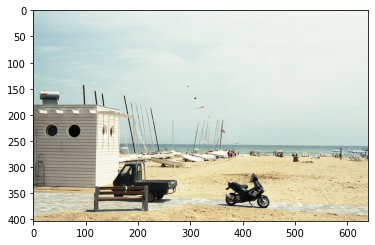

In [13]:
ann_ID = np.random.choice(IDs)
image_ID = coco.anns[ann_ID]['image_id']
images = coco.loadImgs(image_ID)[0]

I = io.imread(images['coco_url'])
plt.imshow(I)


ann_ids = coco_caps.getAnnIds(image_ID)
anns = coco_caps.loadAnns(ann_ids)
coco_caps.showAnns(anns)

# Process Data

## Define dataset

In [10]:
class Dataset:

    def __init__(self, image_Ids, coco, coco_caps):
        self.data = dict()
        self.all_captions = []
        self.all_imageIds = []
        for imageid in image_Ids:
            if random.uniform(0, 1) <= 0.1:
                image = coco.loadImgs(imageid)[0]
                annIds = coco_caps.getAnnIds(imgIds=image['id']);
                anns = coco_caps.loadAnns(annIds)
                image_captions = []
                for caption in anns:
                    caption = caption['caption'].translate(str.maketrans('', '', string.punctuation))
                    caption = caption.replace("-"," ")
                    caption = caption.split()
                    caption = [word.lower() for word in caption]
                    caption = '<start> ' + " ".join(caption) + ' <end>'
                    image_captions.append(caption)

                self.all_captions.append(image_captions)  
                self.all_imageIds.append(image['coco_url']) 
                self.data[image['coco_url']] = image_captions 

    def tokenize(self):
        flatten_list = list(chain.from_iterable(self.all_captions))
        max_length = max(max(len(caption) for caption in captions) for captions in self.all_captions)
        tokenizer = Tokenizer(oov_token='<oov>')
        tokenizer.fit_on_texts(flatten_list)

        total_words = len(tokenizer.word_index) + 1
        index = round(len(self.data.keys()) * 0.8)

        self.train_images = self.all_imageIds[:index]
        self.val_images = self.all_imageIds[index:]
        self.train_captions = self.all_captions[:index]
        self.val_captions = self.all_captions[index:]

        return total_words, tokenizer

    def extract_features(self):
        f_model = Xception(include_top=False, pooling="avg")
        image_size = 224
        self.image_features = {}
        for id in tqdm(self.all_imageIds):
            image = io.imread(id)
            if image.ndim != 3:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            image = cv2.resize(image, (image_size, image_size))
            image = np.expand_dims(image, axis=0)
            image = image / 255.
            feature = f_model.predict(image, verbose=0)
            self.image_features[id] = feature
        return self.image_features

## Define Model

In [14]:
class MyModel:
    def __init__(self, data, total_words):
        total_desc = []
        for key in data.keys():
            [total_desc.append(i) for i in data[key]]
        self.max_length = max(len(j.split()) for j in total_desc)

        input1 = Input(shape=(2048,))
        input2 = Input(shape=(self.max_length,))

        dropout1 = Dropout(0.5)(input1)
        layer2 = Dense(256, activation='relu')(dropout1)

        layer3 = Embedding(total_words, 256, mask_zero=True)(input2)
        
        dropout2 = Dropout(0.5)(layer3)
        layer5 = LSTM(256)(dropout2)

        decoder1 = add([layer2, layer5])
        decoder2 = Dense(256, activation='relu')(decoder1)
        outputs = Dense(total_words, activation='softmax')(decoder2)
        
        self.model = Model(inputs=[input1, input2], outputs=outputs)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')

    def get_generator(self, data, features, tokenizer):
        while 1:
            for key, description_list in data.items():

                feature = features[key][0]
                input_image, input_sequence, output_word = self.create_sequences(tokenizer, self.max_length, description_list, feature)
                yield ([input_image, input_sequence], output_word)
    
    def create_sequences(self, tokenizer, desc_list, feature):
        X1, X2, y = [], [], []
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=total_words)[0]
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)
                
        return np.array(X1), np.array(X2), np.array(y)

    def summary(self):
        print(self.model.summary())

# Train Data

In [55]:
dataset = Dataset(images_ID, coco, coco_caps)

total_words, tokenizer = dataset.tokenize()
image_features = dataset.extract_features()

  0%|          | 0/477 [00:00<?, ?it/s]

In [ ]:
model = MyModel(dataset.data, total_words)

generator = model.get_generator(dataset.data, image_features, tokenizer)

In [20]:
epochs = 5

model.model.fit(generator, epochs=epochs, verbose=1)

Epoch 1/5
12045/12045 [==============================] - 1448s 122ms/step - loss: 3.9770
Epoch 2/5
12045/12045 [==============================] - 1442s 119ms/step - loss: 3.2432
Epoch 3/5
12045/12045 [==============================] - 1457s 121ms/step - loss: 2.8566
Epoch 4/5
12045/12045 [==============================] - 1445s 123ms/step - loss: 2.4328
Epoch 5/5
12045/12045 [==============================] - 1422s 117ms/step - loss: 2.1012



In [18]:
class CaptionGenerator:
    def __init__(self, model, dataset):
        self.dataset = dataset
        self.model = model
        self.path = 'test2017'
        iamge_paths = random.choices(os.listdir(self.path), k=10)
        self.iamge_paths = [self.path + img_path for img_path in iamge_paths]

        self.fmodel = Xception(include_top=False, pooling="avg")
    
    def generate_caption(self, index):
        photo = self.extract_features(index)
        image = Image.open(self.image_paths[index])
        description = self.generate_desc(self.model, tokenizer, photo)
        print(description)
        plt.imshow(image)
        plt.show()

    def extract_features(self, index):
        filename = self.image_paths[index]
        image = Image.open(filename)
        image = image.resize((224 ,224))
        image = np.array(image)
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image / 255.
        feature = self.fmodel.predict(image)
        return feature

    def generate_desc(self, tokenizer, photo):
        in_text = 'start'
        for i in range(self.dataset.max_length):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.dataset.max_length)
            pred = self.model.predict([photo,sequence], verbose=0)
            pred = np.argmax(pred)
            word = self.get_word_by_id(pred, tokenizer)
            if word is None:
                break
            in_text += ' ' + word
            
            if word == 'end':
                break
        return in_text

    def get_word_by_id(self, integer, tokenizer):
        for word, index in tokenizer.word_index.items():
            if index == integer:
                return word
        return None

a living room with a big table


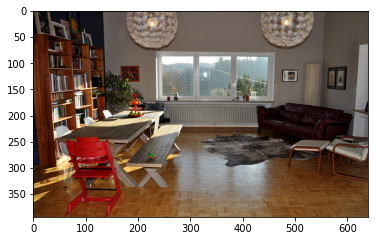

In [11]:
caption_generator = CaptionGenerator(model, dataset)

index = np.random.ranint(0, dataset.max_length)

caption_generator.generate_caption(index)